In [109]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from skimage.morphology import disk
from skimage.transform import hough_line
from scipy.signal import convolve2d
from skimage.morphology import disk
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage import color
from skimage.draw import circle_perimeter

def getImage(image):
    path = '/Users/alexandrasmith/Desktop/Digital Image Processing 793/Assignment 5/'
    im = cv2.imread(path + image, cv2.IMREAD_GRAYSCALE)
    return im

def Otsu(image):
    # normalise histogram
    # calculate number of pixels with each intensity value
    histogram_array = np.bincount(image.flatten(), minlength=256)
    # normalise
    num_pixels = np.sum(histogram_array)
    p = histogram_array/num_pixels
    # loop through each possible threshold value k
    optimal_k = -1
    var = -1 
    # get global mean
    ii = list(range(0, len(p)))
    global_mean = np.sum([a*b for a, b in zip(ii, p)])
    # get global variance
    iii = ii - global_mean
    global_variance = np.sum([(a**2)*b for a, b in zip(iii, p)])
    for k in range(len(p)):
        # compute cumulative sum (probability of class occruing)
        P1 = np.sum(p[:k])
        # compute cumulative mean
        i = list(range(0, k))
        m = np.sum([a*b for a, b in zip(i, p[:k])])
        # compute between-class variance
        class_variance = ((global_mean*P1 - m)**2)/(P1*(1-P1))
        # check if maximum
        if class_variance > var:
            optimal_k = k
            var = class_variance
    # obtain thresholded image
    thresh_img = image.copy()
    thresh_img[image > optimal_k] = 255
    thresh_img[image < optimal_k] = 0
    measure = var/global_variance
    return thresh_img, measure

def get8connected(x, y, shape):
    '''Get points that are 8-connected to a certain pair of coordinates'''

    out = []
    maxx = shape[1]-1; maxy = shape[0]-1
    #top left
    outx = min(max(x-1, 0), maxx); outy = min(max(y-1, 0), maxy)
    out.append((outx, outy))
    #top center
    outx = x; outy = min(max(y-1, 0), maxy)
    out.append((outx, outy))
    #top right
    outx = min(max(x+1,0), maxx); outy = min(max(y-1,0), maxy)
    out.append((outx, outy))
    #left
    outx = min(max(x-1,0), maxx); outy = y
    out.append((outx, outy))
    #right
    outx = min(max(x+1,0), maxx); outy = y
    out.append((outx, outy))
    #bottom left
    outx = min(max(x-1,0), maxx); outy = min(max(y+1,0), maxy)
    out.append((outx, outy))
    #bottom center
    outx = x; outy = min(max(y+1,0), maxy)
    out.append((outx, outy))
    #bottom right
    outx = min(max(x+1,0), maxx); outy = min(max(y+1,0), maxy)
    out.append((outx, outy))
    
    return out

def region_growing(image, seed_points):
    '''Performs region growing for a thresholded image and list of seed point coordinates'''
    r, c = image.shape
    final_img = np.zeros((r, c))
    processed = []
    while(len(seed_points) > 0):
        # get seed point coordinates
        pix = seed_points[0]
        final_img[pix[0], pix[1]] = 255
        for coord in get8connected(pix[0], pix[1], image.shape):
            if image[coord[0], coord[1]] != 0:
                final_img[coord[0], coord[1]] = 255
                if not coord in processed:
                    seed_points.append(coord)
                processed.append(coord)
        # seed_points.pop(0)
        seed_points = np.delete(seed_points, 0, 0)

    return final_img

def colour_seg(image, subimage, k):
    '''Perform colour segmentation of an image given representative colour pixels'''
    r, c, C = image.shape
    # extract colour channels
    red = subimage[:, :, 0]; green = subimage[:, :, 1]; blue = subimage[:, :, 2]

    mean_r = np.mean(red); mean_g = np.mean(green); mean_b = np.mean(blue)
    std_r = np.std(red); std_g = np.std(green); std_b = np.std(blue)
    # print("Mean R, G, B: " + str(mean_r) + ", " + str(mean_g) + ", " + str(mean_b))
    # print("Standard deviation R, G, B: " + str(std_r) + ", " + str(std_g) + ", " + str(std_b))

    # make box
    R = image[:, :, 0]; G = image[:, :, 1]; B = image[:, :, 2]
    # box = i1[int(mean_r - k*std_r):int(mean_r + k*std_r), int(mean_g - k*std_g):int(mean_g + k*std_g), int(mean_b - k*std_b):int(mean_b + k*std_b)]
    r_lower = int(mean_r - k*std_r); r_upper = int(mean_r + k*std_r)
    g_lower = int(mean_g - k*std_g); g_upper = int(mean_g + k*std_g)
    b_lower = int(mean_b - k*std_b); b_upper = int(mean_b + k*std_b)
    # decide if points in image lie in box
    final = np.zeros((r, c))
    for i in range(r):
        for j in range(c):
            red_pixel = R[i, j]; green_pixel = G[i, j]; blue_pixel = B[i, j]
            if red_pixel > r_lower and red_pixel < r_upper and green_pixel > g_lower and green_pixel < g_upper and blue_pixel > b_lower and blue_pixel < b_upper:
                final[i, j] = 255
    
    return final

(168, 300, 3)


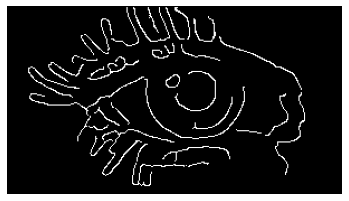

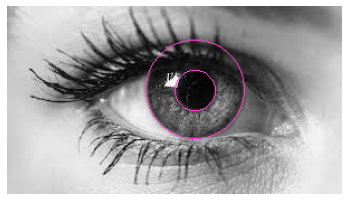

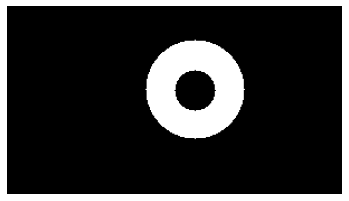

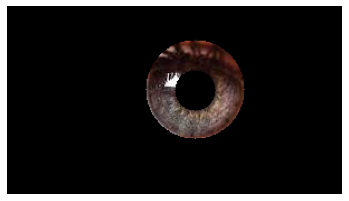

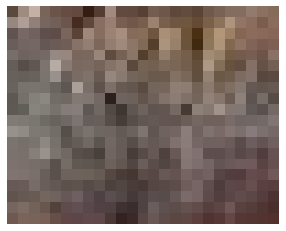

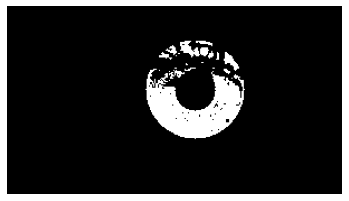

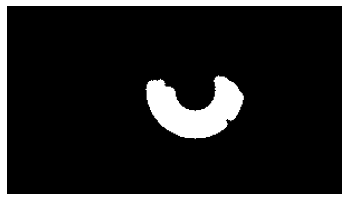

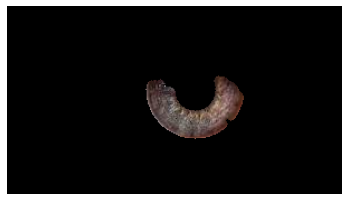

In [157]:
# QUESTION 4 : different attempt
path = '/Users/alexandrasmith/Desktop/Digital Image Processing 793/Assignment 5/'
e1 = cv2.imread(path + 'eye_1.jpg'); e2 = cv2.imread(path + 'eye_2.jpg'); e3 = cv2.imread(path + 'eye_3.jpg')
eye1 = cv2.cvtColor(e1, cv2.COLOR_BGR2RGB); eye2 = cv2.cvtColor(e2, cv2.COLOR_BGR2RGB); eye3 = cv2.cvtColor(e3, cv2.COLOR_BGR2RGB)
# convert to greyscale
grey1 = cv2.cvtColor(eye1, cv2.COLOR_RGB2GRAY); grey2 = cv2.cvtColor(eye2, cv2.COLOR_RGB2GRAY); grey3 = cv2.cvtColor(eye3, cv2.COLOR_RGB2GRAY)

r1, c1 = grey1.shape
# detect edges
edges1 = canny(grey1, sigma=3, low_threshold=10, high_threshold=50)
plt.figure(); plt.axis('off'); plt.imshow(edges1, cmap="gray")
# detect radii
hough_radii = np.arange(18, 60, 2); hough_res = hough_circle(edges1, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

# Draw them
out1 = color.gray2rgb(grey1)
cx = np.delete(cx, 1); cy = np.delete(cy, 1); radii = np.delete(radii, 1)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=out1.shape)
    out1[circy, circx] = (255, 68, 204)

m1 = np.zeros((r1, c1)); n1 = np.zeros((r1, c1))
cv2.circle(m1, (cx[0], cy[0]), radii[0], (255, 255, 255), -1)
cv2.circle(n1, (cx[1], cy[1]), radii[1], (255, 255, 255), -1)
plt.figure(); plt.axis('off'); plt.imshow(out1, cmap="gray")

mask1 = n1 - m1
plt.figure(); plt.axis('off'); plt.imshow(mask1, cmap="gray")
# extract just iris from original image
iris1 = eye1.copy()
for i in range(r1):
   for j in range(c1):
      if mask1[i, j] == 255:
         iris1[i, j, :] = eye1[i, j, :]
      else:
         iris1[i, j, :] = 0
plt.figure(); plt.axis("off")
plt.imshow(iris1)

# colour segmentation
print(iris1.shape)
sub1 = iris1[95:115, 155:180, :]
plt.figure(); plt.axis('off'); plt.imshow(sub1)
out1 = colour_seg(iris1, sub1, 3)
plt.figure(); plt.axis('off'); plt.imshow(out1, cmap="gray")

k = disk(1)
morph = cv2.morphologyEx(out1, cv2.MORPH_CLOSE, k, iterations=1)
k2 = disk(4)
mask1 = cv2.morphologyEx(morph, cv2.MORPH_OPEN, k2, iterations=1)
plt.figure(); plt.axis("off"); plt.imshow(mask1, cmap="gray")
final1 = eye1.copy()
for i in range(r1):
   for j in range(c1):
         if mask1[i, j] == 0:
            final1[i, j, :] = 0
plt.figure(); plt.axis('off'); plt.imshow(final1)


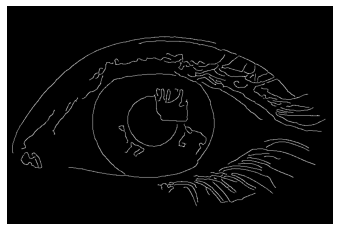

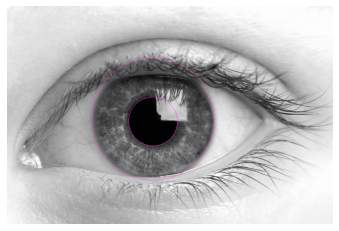

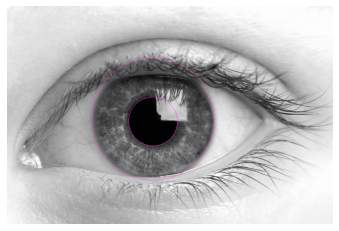

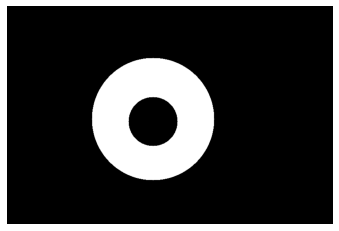

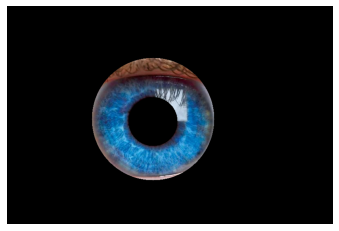

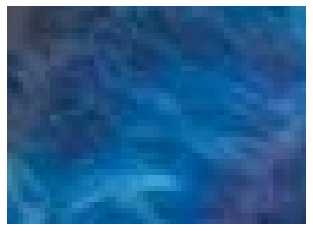

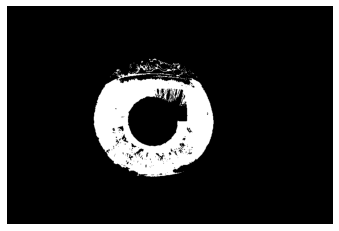

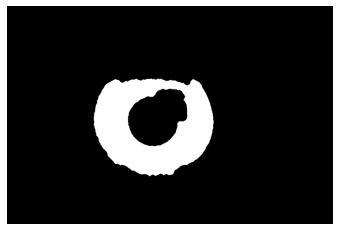

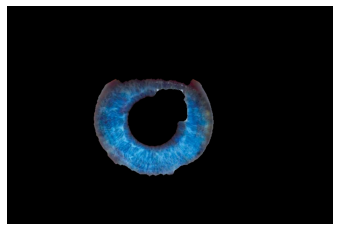

In [160]:
r2, c2 = grey2.shape
# detect edges
edges2 = canny(grey2, sigma=3, low_threshold=10, high_threshold=50)
plt.figure(); plt.axis('off'); plt.imshow(edges2, cmap="gray")
# detect radii
hough_radii = np.arange(60, 200, 2); hough_res = hough_circle(edges2, hough_radii)

# Select prominent circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=6)
# Draw circles
out2 = color.gray2rgb(grey2)
# Delete some circles
cx = [cx[i] for i in (1, -1)]; cy = [cy[i] for i in (1, -1)]; radii = [radii[i] for i in (1, -1)]
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=out2.shape)
    out2[circy, circx] = (255, 68, 204)

plt.figure(); plt.axis('off'); plt.imshow(out2, cmap="gray")

m1 = np.zeros((r2, c2)); n1 = np.zeros((r2, c2))
cv2.circle(m1, (cx[0], cy[0]), radii[0], (255, 255, 255), -1)
cv2.circle(n1, (cx[1], cy[1]), radii[1], (255, 255, 255), -1)
plt.figure(); plt.axis('off'); plt.imshow(out2, cmap="gray")

mask2 = n1 - m1
plt.figure(); plt.axis('off'); plt.imshow(mask2, cmap="gray")
# extract just iris from original image
iris2 = eye2.copy()
for i in range(r2):
   for j in range(c2):
      if mask2[i, j] == 255:
         iris2[i, j, :] = eye2[i, j, :]
      else:
         iris2[i, j, :] = 0
plt.figure(); plt.axis("off")
plt.imshow(iris2)

# colour segmentation
sub2 = iris2[220:260, 240:295, :]
plt.figure(); plt.axis('off'); plt.imshow(sub2)
out2 = colour_seg(iris2, sub2, 4)
plt.figure(); plt.axis('off'); plt.imshow(out2, cmap="gray")

k = disk(2)
morph = cv2.morphologyEx(out2, cv2.MORPH_OPEN, k, iterations=2)
k2 = disk(4)
mask2 = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, k2, iterations=2)
plt.figure(); plt.axis("off"); plt.imshow(mask2, cmap="gray")

final2 = eye2.copy()
for i in range(r2):
   for j in range(c2):
         if mask2[i, j] == 0:
            final2[i, j, :] = 0
plt.figure(); plt.axis('off'); plt.imshow(final2)


255


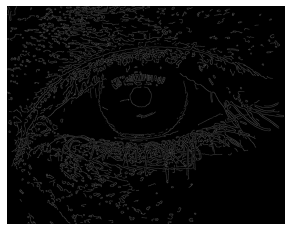

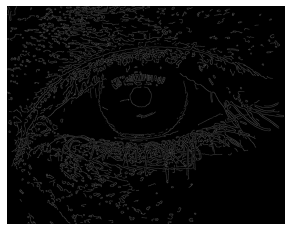

In [179]:
r3, c3 = grey3.shape
# detect edges
edges3 = canny(grey3, sigma=3, low_threshold=5, high_threshold=15)
plt.figure(); plt.axis('off'); plt.imshow(edges3, cmap="gray")

e = np.zeros((r3, c3))
for i in range(r3):
    for j in range(c3):
        if edges3[i, j] != 0:
            e[i, j] = 255
plt.figure(); plt.axis('off'); plt.imshow(e, cmap="gray")
# detect radii
# hough_radii = np.arange(210, 430, 2); hough_res = hough_circle(edges3, hough_radii)

# # Select most prominent circles
# accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=6)

# # Draw them
# out3 = color.gray2rgb(grey3)
# # cx = [cx[i] for i in (1, -1)]; cy = [cy[i] for i in (1, -1)]; radii = [radii[i] for i in (1, -1)]
# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = circle_perimeter(center_y, center_x, radius, shape=out3.shape)
#     out3[circy, circx] = (255, 68, 204)

# plt.figure(); plt.axis('off'); plt.imshow(out3, cmap="gray")

# m1 = np.zeros((r3, c3)); n1 = np.zeros((r3, c3))
# cv2.circle(m1, (cx[0], cy[0]), radii[0], (255, 255, 255), -1)
# cv2.circle(n1, (cx[1], cy[1]), radii[1], (255, 255, 255), -1)
# plt.figure(); plt.axis('off'); plt.imshow(out3, cmap="gray")

# mask2 = n1 - m1
# plt.figure(); plt.axis('off'); plt.imshow(mask3, cmap="gray")
# # extract just iris from original image
# iris3 = eye3.copy()
# for i in range(r3):
#    for j in range(c3):
#       if mask3[i, j] == 255:
#          iris3[i, j, :] = eye3[i, j, :]
#       else:
#          iris3[i, j, :] = 0
# plt.figure(); plt.axis("off")
# plt.imshow(iris3)

# # colour segmentation
# print(iris3.shape)
# sub3 = iris3[740:950, 870:1100, :]
# plt.figure(); plt.axis('off'); plt.imshow(sub3)
# out3 = colour_seg(iris1, sub1, 3.5)
# plt.figure(); plt.axis('off'); plt.imshow(out3, cmap="gray")

# k = disk(1)
# morph = cv2.morphologyEx(out1, cv2.MORPH_CLOSE, k, iterations=1)
# k2 = disk(4)
# mask1 = cv2.morphologyEx(morph, cv2.MORPH_OPEN, k2, iterations=1)
# plt.figure(); plt.axis("off"); plt.imshow(mask3, cmap="gray")

# final3 = eye3.copy()
# for i in range(r3):
#    for j in range(c3):
#          if mask3[i, j] == 0:
#             final3[i, j, :] = 0
# plt.figure(); plt.axis('off'); plt.imshow(final3)

Separability measure: 0.746588155853912


<ipython-input-41-c25221a57851>:38: RuntimeWarning: invalid value encountered in double_scalars
  class_variance = ((global_mean*P1 - m)**2)/(P1*(1-P1))


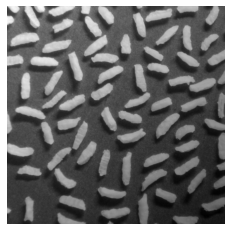

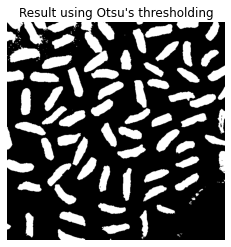

In [97]:
# QUESTION 2
rice = getImage('rice_shaded.tif') # 600 x 600
plt.figure()
plt.axis("off")
plt.imshow(rice, cmap="gray")

# a)
thresh, eta = Otsu(rice)
print("Separability measure: {}".format(eta))
plt.figure()
plt.axis("off")
plt.title("Result using Otsu's thresholding")
plt.imshow(thresh, cmap="gray")

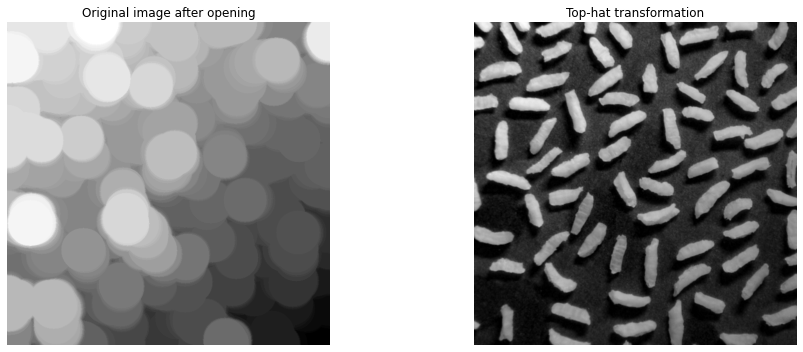

Separability measure: 0.836616421323277


<ipython-input-266-937c72297689>:38: RuntimeWarning: invalid value encountered in double_scalars
  class_variance = ((global_mean*P1 - m)**2)/(P1*(1-P1))


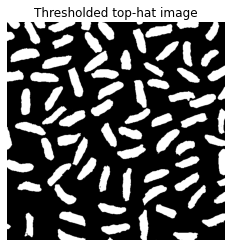

In [269]:
# b)
se = disk(40)
open = cv2.morphologyEx(rice, cv2.MORPH_OPEN, se)
top_hat = rice - open

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow(open, cmap='gray')
plt.title("Original image after opening")
plt.axis('off')
plt.subplot(132)
plt.imshow(top_hat, cmap='gray')
plt.title("Top-hat transformation")
plt.axis('off')
plt.tight_layout()
plt.show()

thresh2, eta2 = Otsu(top_hat.astype(np.uint8))
print("Separability measure: {}".format(eta2))
plt.figure()
plt.axis("off")
plt.title("Thresholded top-hat image")
plt.imshow(thresh2, cmap="gray")

Text(0.5, 1.0, 'Variable thresholding using 9 subregions')

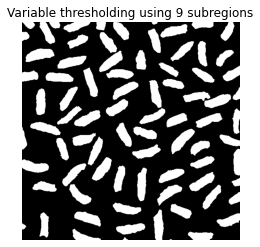

In [99]:
# c) variable thresholding
r, c = rice.shape
# number to split rows and columns into
s = 3
# number of subregions
num_regions = s**2
row_width = int(r/s)
col_width = int(c/s)
final_img = np.zeros((r, c))
# split image into subregions
for i in range(s):
    for j in range(s):
        region = rice[i*row_width:(i+1)*row_width, j*col_width: (j+1)* col_width]
        # plt.figure()
        # plt.axis("off")
        # plt.imshow(region, cmap="gray")
        # thresh, measure = Otsu(region)
        (T, thresh) = cv2.threshold(region, 20, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        final_img[i*row_width:(i+1)*row_width, j*col_width: (j+1)* col_width] = thresh
plt.figure(); plt.axis("off")
plt.imshow(final_img, cmap="gray"); plt.title("Variable thresholding using " + str(num_regions) + " subregions")


<ipython-input-129-2a6c31c07dd9>:35: RuntimeWarning: invalid value encountered in double_scalars
  class_variance = ((global_mean*P1 - m)**2)/(P1*(1-P1))


243


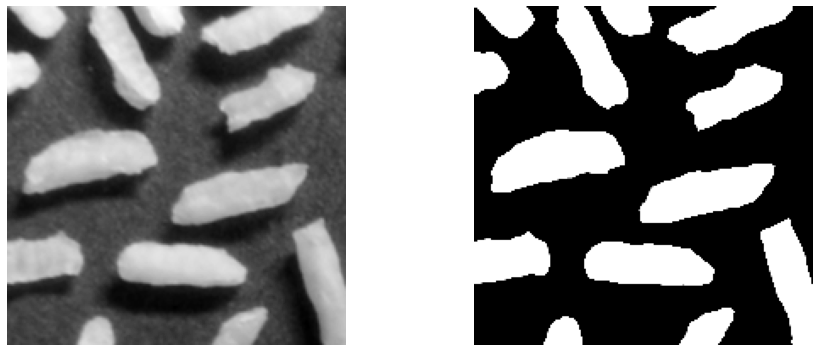

In [135]:
i = 0; j = 0
region = rice[i*row_width:(i+1)*row_width, j*col_width: (j+1)* col_width]
t, m = Otsu(region)
print(np.max(region))
# (T, thresh) = cv2.threshold(region, 20, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(region, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(t, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()

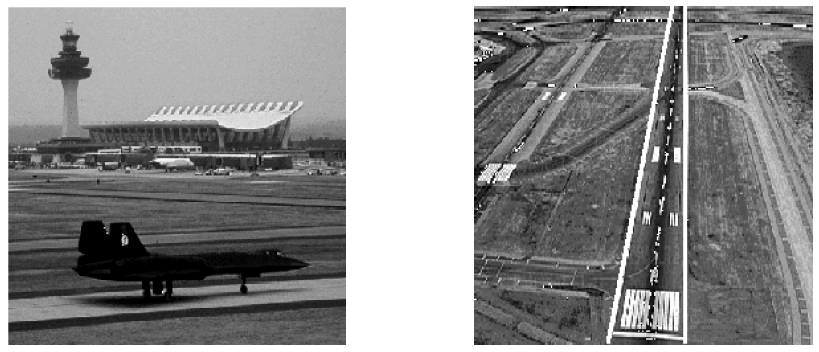

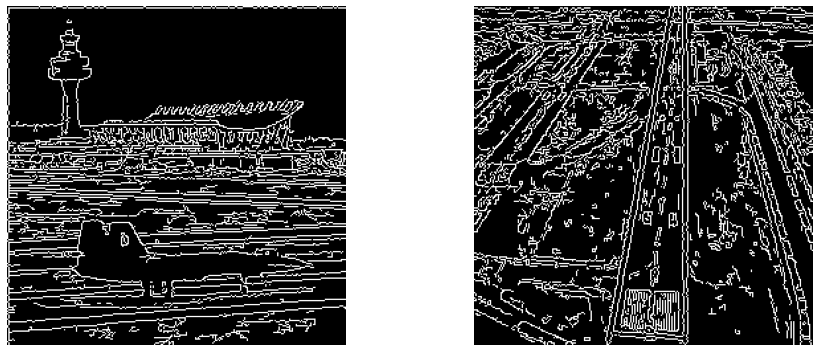

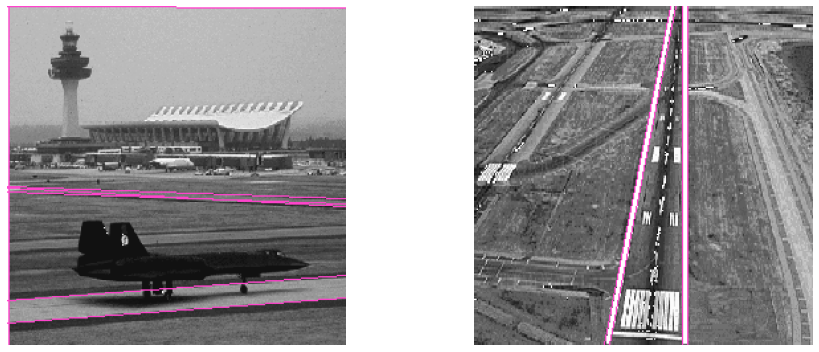

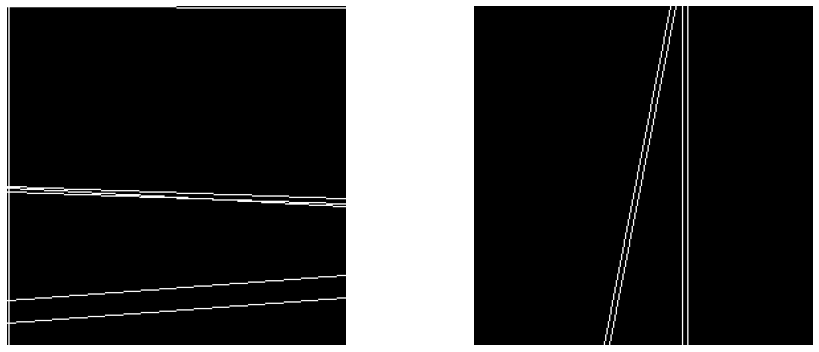

In [105]:
# QUESTION 3
a1 = getImage("airport_1.bmp")
a2 = getImage("airport_2.bmp")
r1, c1 = a1.shape; r2, c2 = a2.shape
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(a1, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(a2, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()

edges1 = cv2.Canny(a1, 50, 150); edges2 = cv2.Canny(a2, 120, 250)

plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(edges1, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(edges2, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()

lines1 = cv2.HoughLines(edges1, 1, np.pi/180, 140)
l1 = cv2.merge((a1, a1, a1)); L1 = np.zeros((r1, c1))
for line in lines1:
   rho,theta = line[0]
   a = np.cos(theta)
   b = np.sin(theta)
   x0 = a*rho
   y0 = b*rho
   x1 = int(x0+1000*(-b))
   y1 = int(y0+1000*(a))
   x2 = int(x0-1000*(-b))
   y2 = int(y0-1000*(a))
   cv2.line(l1, (x1, y1), (x2, y2), (255, 68, 204), 1)
   cv2.line(L1, (x1, y1), (x2, y2), (255, 255, 255), 1)

lines2 = cv2.HoughLines(edges2, 1, np.pi/180, 140)
l2 = cv2.merge((a2, a2, a2)); L2 = np.zeros((r2, c2))
for line in lines2:
   rho,theta = line[0]
   a = np.cos(theta)
   b = np.sin(theta)
   x0 = a*rho
   y0 = b*rho
   x1 = int(x0+1000*(-b))
   y1 = int(y0+1000*(a))
   x2 = int(x0-1000*(-b))
   y2 = int(y0-1000*(a))
   cv2.line(l2, (x1, y1), (x2, y2), (255, 68, 204), 1)
   cv2.line(L2, (x1, y1), (x2, y2), (255, 255, 255), 1)

# plot resulting lines on original images
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(l1, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(l2, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()
# plot images containing just the lines
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(L1, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(L2, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()


[[False False False ...  True  True  True]
 [False  True False ... False False False]
 [False  True False ... False False False]
 ...
 [False  True False ... False False False]
 [False  True False ... False False False]
 [False  True False ... False False False]]


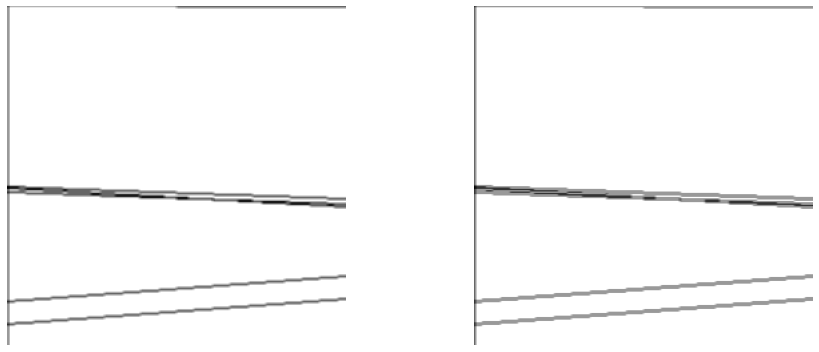

In [4]:
# detect if vertical/horizontal lines present in the image
H_kernel = (-1)*np.ones((3, 3), np.uint8)
H_kernel[1, :] = -2
V_kernel = (-1)*np.ones((3, 3), np.uint8)
V_kernel[:, 1] = -2

h1 = convolve2d(L1, H_kernel, 'valid')
v1 = convolve2d(L1, V_kernel, 'valid')

print(np.abs(h1) > np.abs(v1))
# h1 = cv2.filter2D(L1, -1, H_kernel)

plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(h1, cmap='gray'); plt.axis('off')
plt.subplot(132); plt.imshow(v1, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()


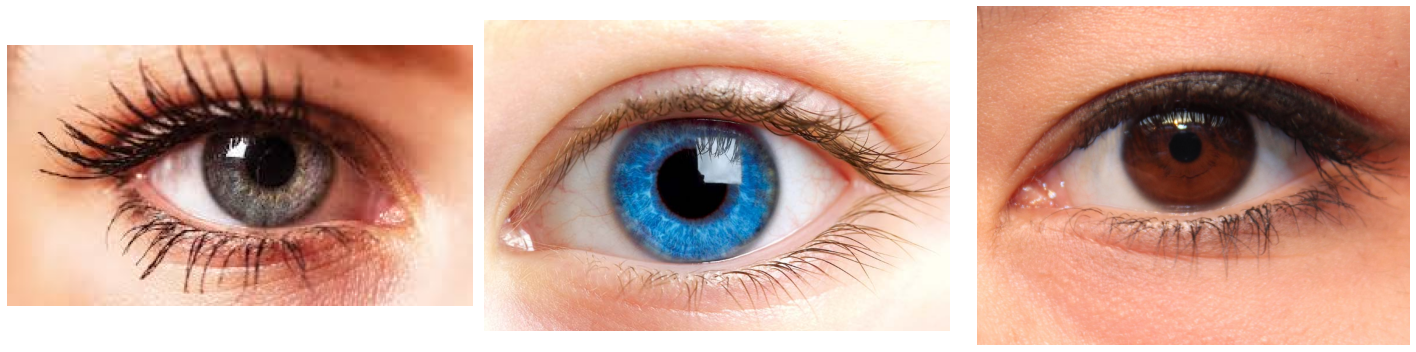

In [24]:
# QUESTION 4
path = '/Users/alexandrasmith/Desktop/Digital Image Processing 793/Assignment 5/'
e1 = cv2.imread(path + 'eye_1.jpg'); e2 = cv2.imread(path + 'eye_2.jpg'); e3 = cv2.imread(path + 'eye_3.jpg')
eye1 = cv2.cvtColor(e1, cv2.COLOR_BGR2RGB); eye2 = cv2.cvtColor(e2, cv2.COLOR_BGR2RGB); eye3 = cv2.cvtColor(e3, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(eye1); plt.axis('off')
plt.subplot(132); plt.imshow(eye2); plt.axis('off')
plt.subplot(133); plt.imshow(eye3); plt.axis('off')
plt.tight_layout(); plt.show()

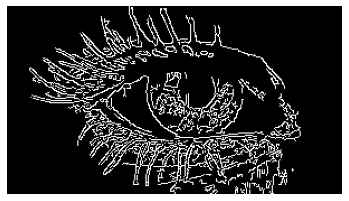

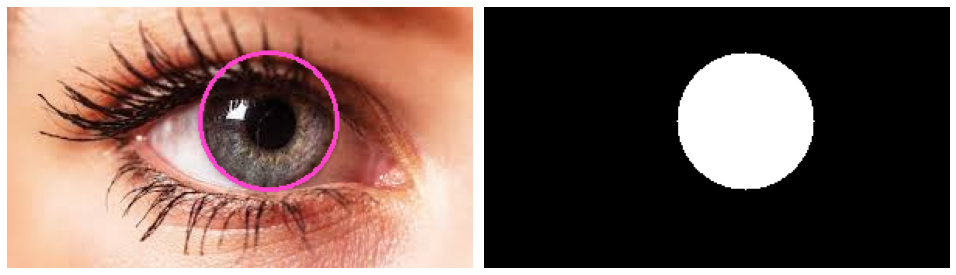

(168, 300, 3)


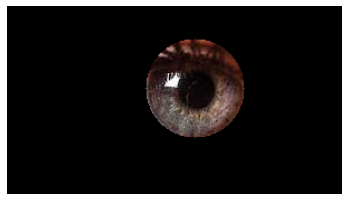

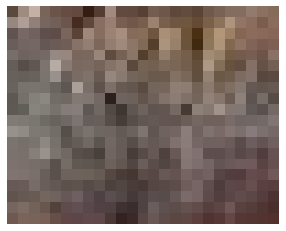

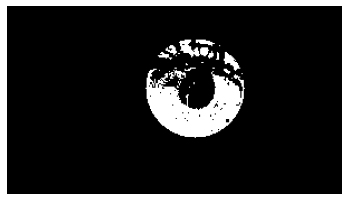

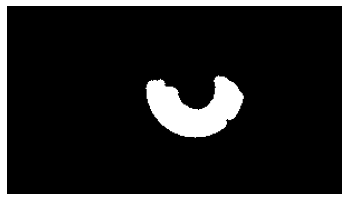

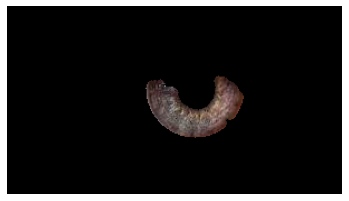

In [68]:
# convert to greyscale
grey1 = cv2.cvtColor(eye1, cv2.COLOR_RGB2GRAY); grey2 = cv2.cvtColor(eye2, cv2.COLOR_RGB2GRAY); grey3 = cv2.cvtColor(eye3, cv2.COLOR_RGB2GRAY)

# create mask
r1, c1 = grey1.shape
mask1 = np.zeros((r1, c1))
# blur image
img3 = cv2.medianBlur(grey3, 3)

edges1 = cv2.Canny(grey1, 100, 200);
plt.figure(); plt.axis("off")
plt.imshow(edges1, cmap="gray")

circles1 = cv2.HoughCircles(grey1, cv2.HOUGH_GRADIENT, 1.3, 100)
output1 = eye1.copy() 

if circles1 is not None:
   # Get the (x, y, r) as integers
   circles = np.round(circles1[0, :]).astype("int")
   # loop over the circles
   for (x, y, r) in circles:
      cv2.circle(output1, (x, y), r, (255, 68, 204), 2)
      cv2.circle(mask1, (x, y), r, (255, 255, 255), -1)

plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(output1); plt.axis('off')
plt.subplot(132); plt.imshow(mask1, cmap="gray"); plt.axis('off')
plt.tight_layout(); plt.show()

# extract just iris and pupil from original image
iris1 = eye1.copy()
for i in range(r1):
   for j in range(c1):
      if mask1[i, j] == 255:
         iris1[i, j, :] = eye1[i, j, :]
      else:
         iris1[i, j, :] = 0
plt.figure(); plt.axis("off")
plt.imshow(iris1)

# # delete eyelids/eyelashes from image
# R1, T1 = cv2.threshold(cv2.cvtColor(iris1, cv2.COLOR_RGB2GRAY), 25, 255, cv2.THRESH_BINARY)
# k = disk(1)
# d = cv2.dilate(T1, k, iterations = 1)
# e = cv2.erode(d, k, iterations = 2)

# plt.figure(figsize=(20, 5))
# plt.subplot(131); plt.imshow(T1, cmap="gray"); plt.axis('off')
# plt.subplot(132); plt.imshow(e, cmap="gray"); plt.axis('off')
# plt.tight_layout(); plt.show()

# morph = cv2.morphologyEx(T1, cv2.MORPH_OPEN, k, iterations=2)
# plt.figure(); plt.axis("off")
# plt.imshow(morph, cmap="gray")

# colour segmentation
print(iris1.shape)
sub1 = iris1[95:115, 155:180, :]
plt.figure(); plt.axis('off'); plt.imshow(sub1)
out1 = colour_seg(iris1, sub1, 3)
plt.figure(); plt.axis('off'); plt.imshow(out1, cmap="gray")

k = disk(1)
morph = cv2.morphologyEx(out1, cv2.MORPH_CLOSE, k, iterations=1)
k2 = disk(4)
mask1 = cv2.morphologyEx(morph, cv2.MORPH_OPEN, k2, iterations=1)
plt.figure(); plt.axis("off"); plt.imshow(mask1, cmap="gray")

final1 = eye1.copy()
for i in range(r1):
   for j in range(c1):
         if mask1[i, j] == 0:
            final1[i, j, :] = 0
plt.figure(); plt.axis('off'); plt.imshow(final1)

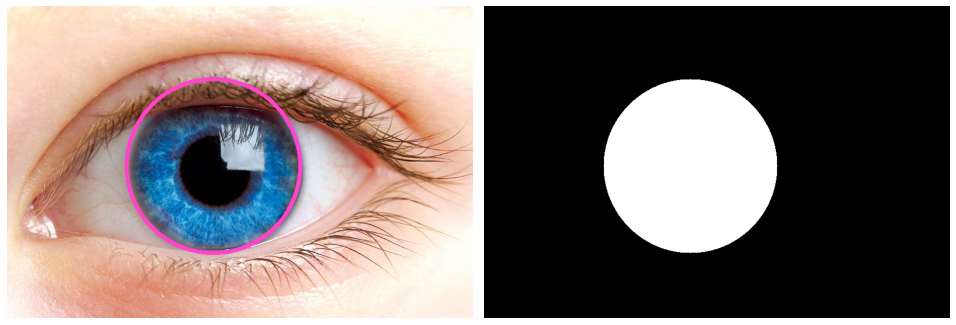

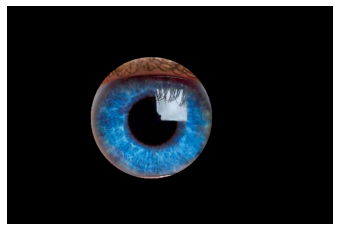

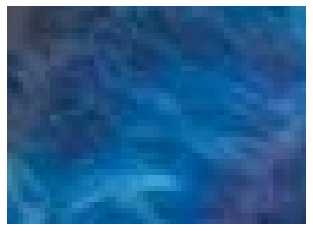

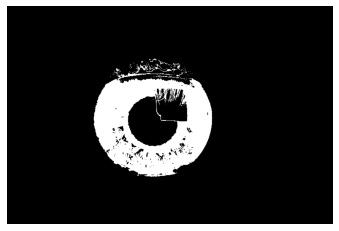

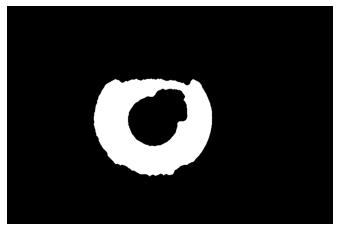

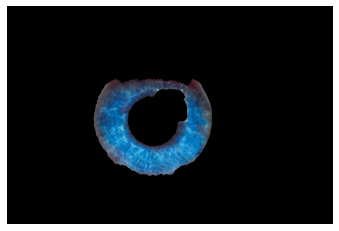

In [85]:
# edges2 = cv2.Canny(grey2, 50, 110);
# plt.figure(); plt.axis("off")
# plt.imshow(edges2, cmap="gray")

# t, thresh = cv2.threshold(grey1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# plt.figure(); plt.axis("off")
# plt.imshow(thresh, cmap="gray")

# create mask
r2, c2 = grey2.shape
mask2 = np.zeros((r2, c2))

kernel = np.ones((5, 5),np.uint8)
blur = cv2.GaussianBlur(grey2, (5, 5), 1)
erosion = cv2.erode(blur, kernel, iterations = 2)
ret3, th3 = cv2.threshold(erosion, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
k = np.ones((3, 3),np.uint8)
e = cv2.dilate(th3, kernel, iterations = 2)
# plt.figure()
# plt.imshow(th3, cmap="gray")
# plt.figure()
# plt.imshow(e, cmap="gray")
output2 = eye2.copy()
circles2 = cv2.HoughCircles(e, cv2.HOUGH_GRADIENT, 4, 500, param1=200, param2=100, minRadius=100, maxRadius=200)
if circles2 is not None:
   # Get the (x, y, r) as integers
   circles = np.round(circles2[0, :]).astype("int")
   # loop over the circles
   for (x, y, r) in circles:
      cv2.circle(output2, (x, y), r, (255, 68, 204), 6)
      cv2.circle(mask2, (x, y), r, (255, 255, 255), -1)

plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(output2); plt.axis('off')
plt.subplot(132); plt.imshow(mask2, cmap="gray"); plt.axis('off')
plt.tight_layout(); plt.show()

# extract just iris and pupil from original image
iris2 = eye2.copy()
for i in range(r2):
   for j in range(c2):
      if mask2[i, j] == 255:
         iris2[i, j, :] = eye2[i, j, :]
      else:
         iris2[i, j, :] = 0
plt.figure(); plt.axis("off")
plt.imshow(iris2)

# delete eyelids/eyelashes from image
# R2, T2 = cv2.threshold(cv2.cvtColor(iris2, cv2.COLOR_RGB2GRAY), 40, 255, cv2.THRESH_BINARY)
# k = disk(3)
# d = cv2.dilate(T2, k, iterations = 1)
# e = cv2.erode(d, k, iterations = 2)

# plt.figure(figsize=(20, 5))
# plt.subplot(131); plt.imshow(T2, cmap="gray"); plt.axis('off')
# plt.subplot(132); plt.imshow(e, cmap="gray"); plt.axis('off')
# plt.tight_layout(); plt.show()

# morph = cv2.morphologyEx(T2, cv2.MORPH_OPEN, k, iterations=2)
# plt.figure(); plt.axis("off")
# plt.imshow(morph, cmap="gray")

# colour segmentation
sub2 = iris2[220:260, 240:295, :]
plt.figure(); plt.axis('off'); plt.imshow(sub2)
out2 = colour_seg(iris2, sub2, 4)
plt.figure(); plt.axis('off'); plt.imshow(out2, cmap="gray")

k = disk(2)
morph = cv2.morphologyEx(out2, cv2.MORPH_OPEN, k, iterations=2)
k2 = disk(4)
mask2 = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, k2, iterations=2)
plt.figure(); plt.axis("off"); plt.imshow(mask2, cmap="gray")

final2 = eye2.copy()
for i in range(r2):
   for j in range(c2):
         if mask2[i, j] == 0:
            final2[i, j, :] = 0
plt.figure(); plt.axis('off'); plt.imshow(final2)

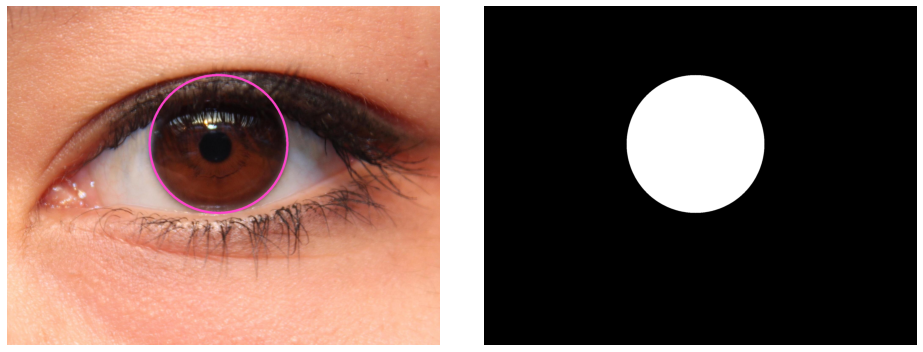

(1603, 2048, 3)


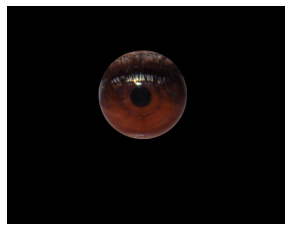

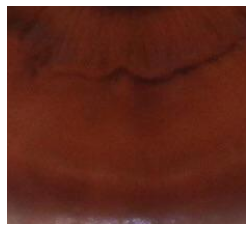

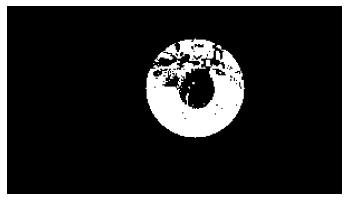

In [95]:
kernel = np.ones((5, 5),np.uint8)
blur = cv2.GaussianBlur(grey3, (5, 5), 1)
erosion = cv2.erode(blur, kernel, iterations = 2)
ret, th = cv2.threshold(erosion, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
k = np.ones((3, 3),np.uint8)
e = cv2.dilate(th, kernel, iterations = 3)
# plt.figure()
# plt.imshow(th, cmap="gray")
# plt.figure()
# plt.imshow(e, cmap="gray")

# create mask
r3, c3 = grey3.shape
mask3 = np.zeros((r3, c3))

circles3 = cv2.HoughCircles(e, cv2.HOUGH_GRADIENT, 3, 900, param1=200, param2=100, minRadius=100, maxRadius=500)
output3 = eye3.copy()
if circles3 is not None:
   # Get the (x, y, r) as integers
   circles = np.round(circles3[0, :]).astype("int")
   # loop over the circles
   for (x, y, r) in circles:
      cv2.circle(output3, (x, y), r, (255, 68, 204), 10)
      cv2.circle(mask3, (x, y), r, (255, 255, 255), -1)

plt.figure(figsize=(20, 5))
plt.subplot(131); plt.imshow(output3); plt.axis('off')
plt.subplot(132); plt.imshow(mask3, cmap="gray"); plt.axis('off')
plt.tight_layout(); plt.show()

# extract just iris and pupil from original image
iris3 = eye3.copy()
for i in range(r3):
   for j in range(c3):
      if mask3[i, j] == 255:
         iris3[i, j, :] = eye3[i, j, :]
      else:
         iris3[i, j, :] = 0
plt.figure(); plt.axis("off")
plt.imshow(iris3)

# colour segmentation
print(iris3.shape)
sub3 = iris3[740:950, 870:1100, :]
plt.figure(); plt.axis('off'); plt.imshow(sub3)
out3 = colour_seg(iris1, sub1, 3.5)
plt.figure(); plt.axis('off'); plt.imshow(out3, cmap="gray")

# k = disk(1)
# morph = cv2.morphologyEx(out1, cv2.MORPH_CLOSE, k, iterations=1)
# k2 = disk(4)
# mask1 = cv2.morphologyEx(morph, cv2.MORPH_OPEN, k2, iterations=1)
# plt.figure(); plt.axis("off"); plt.imshow(mask3, cmap="gray")

# final3 = eye3.copy()
# for i in range(r3):
#    for j in range(c3):
#          if mask3[i, j] == 0:
#             final3[i, j, :] = 0
# plt.figure(); plt.axis('off'); plt.imshow(final3)

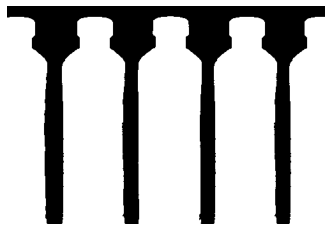

In [93]:
# QUESTION 1

# a)
bottles = getImage('bottles.jpg')
r, thresh = cv2.threshold(bottles, 5, 255, cv2.THRESH_BINARY)
plt.figure(); plt.axis('off'); plt.imshow(thresh, cmap="gray")

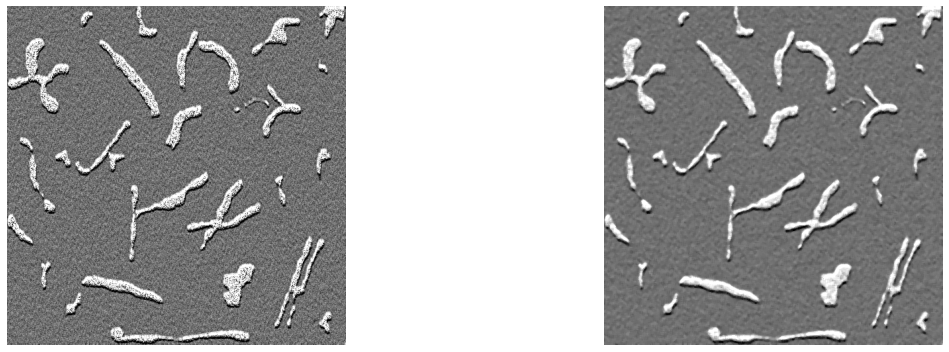

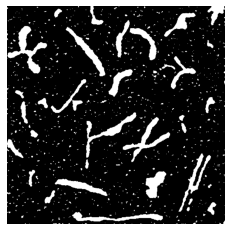

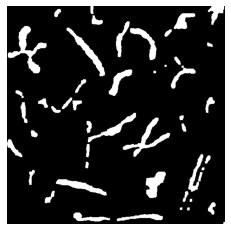

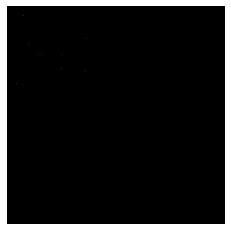

In [22]:
# b)
seg = getImage('segments.jpg')
blur = cv2.medianBlur(seg, 5)

plt.figure(figsize=(20, 5))
plt.subplot(121); plt.imshow(seg, cmap="gray"); plt.axis('off')
plt.subplot(122); plt.imshow(blur, cmap="gray"); plt.axis('off')
plt.tight_layout(); plt.show()

r, thresh = cv2.threshold(blur, 125, 255, cv2.THRESH_BINARY)
plt.figure(); plt.axis('off'); plt.imshow(thresh, cmap="gray")

k = np.ones((3, 3))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, k, iterations=2)
plt.figure(); plt.axis('off'); plt.imshow(morph, cmap="gray")

# perform region growing
seedx = [22, 88, 115, 76, 114, 181, 147, 152]
seedy = [38, 51, 77, 183, 128, 22, 127, 183]
seed = np.column_stack((seedx, seedy))
out = region_growing(morph, seed)
plt.figure(); plt.axis('off'); plt.imshow(out, cmap="gray")